# CS 237 Spring 2020, Homework 12 

### Due date: May 3rd


## Homework 12 General Instructions

This homework contains programming problems with some commentary on interpreting the results. Its goal is simply to exercise your understanding of machine learning, especially Logistic Regression and Naive Bayes classification.  

In [1]:
# General useful imports
import numpy as np
from numpy import arange,linspace,mean, var, std, corrcoef, transpose, ones,log, mean
from numpy.linalg import inv
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.mlab as mlab
from numpy.random import random, randint, uniform, shuffle, seed
import math
from collections import Counter, defaultdict
import pandas as pd
import os,glob,re

%matplotlib inline

# Basic Numpy statistical functions

X = [1,2,3]

# mean of a list
mean(X)             # might need to use np.mean, np.var, and np.std

# population variance
var(X)

# sample variance    ddof = delta degrees of freedom, df = len(X) - ddof
var(X,ddof=1)                 

# population standard deviation
std(X)

# sample standard deviation
std(X,ddof=1)


# Scipy statistical functions

# Scipy Stats Library Functions, see:
# https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.statistics.html


# Calculate the correlation coefficient rho(X,Y)


def rho(X,Y):
    return corrcoef(X,Y)[0][1]

def R2(X,Y):
    return corrcoef(X,Y)[0][1] ** 2

# Utility functions

        
# Round to 2 decimal places
def round2(x):
    return round(float(x)+0.00000000001,2)

# Round to 4 decimal places
def round4(x):
    return round(float(x)+0.00000000001,4)

def round4List(X):
    return [round(float(x)+0.00000000001,4) for x in X]

def probToPercent(p):
    pc = p*100
    if round(pc) == pc:
        return str(round(pc)) + "%"
    else:
        return str(round(pc,2))+ "%"

def classification_corpus_reader(data_dirs):
    # what is form of input
    if type(data_dirs) == str:
        data_dirs = [ data_dirs ]         # rename to singleton list
    
    ws = []
    ds = []
    for d in data_dirs:
        (ws1,ds1) = classification_corpus_reader_aux(d)
        ws += ws1
        ds += ds1
    return (ws,ds)


def classification_corpus_reader_aux(data_dir):
 
    # get subdirectories for each category = labels for each document
    
    if data_dir[-1] != '/':
        data_dir += '/'
    if data_dir[:2] != './':
        data_dir = './' + data_dir   

    sub_dirs = glob.glob( data_dir + "*/" )

    labels = [ os.path.basename(os.path.dirname(p)) for p in sub_dirs ]
   
    words = []

    docs = []
    
    for k in range(len(sub_dirs)):
        for path in glob.glob(sub_dirs[k]+'*.txt'):
            try:
                # Open the file for reading inside a try block to make sure an opened file is indeed closed
                f = open(path,'r',encoding='latin-1')
        
                lines = f.readlines()      #  get all lines from file
                          
                txt = []
                for w in re.findall(r'\w+', " ".join(lines)):
                    w = w.lower()           # put in lower case so is case-insensitive
                    txt.append(w)           # collect text into list of words
                    
                words += txt                # add to list of all words
               
                docs.append( (txt,labels[k]) )
            except IOError:
                print("Couldn't open", fileid)
            finally:    # close the file that was opened        
                f.close()
        
    return ( words, docs )


## Problem One: Logistic Regression

This problem will review the process of logistic regression, using an example similar to what was
shown in class. 





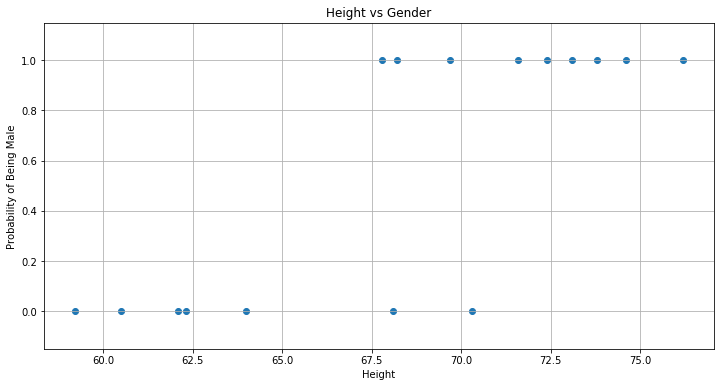

In [2]:
Height = [59.2, 60.5, 62.1, 62.3, 73.8, 64.0, 71.6, 67.8,68.1,68.2,69.7,70.3, 72.4,73.1,74.6,76.2]

Gender = [0,0,0,0,1,0,1,1,0,1,1,0,1,1,1,1]

plt.figure(figsize=(12,6))
plt.grid()
plt.title("Height vs Gender")
plt.ylim([-0.15,1.15])
plt.xlabel("Height")
plt.ylabel("Probability of Being Male")
plt.scatter(Height,Gender)
plt.show()

The following code implements the algorithm for Logistic Regression. The most significant part of the
algorithm is searching for the best parameters for $b$ and $m$ by gradient descent. 

In [3]:
def s(z):
    return 1/(1+np.exp(-z))

def s_inv(p):
    return log(p/(1-p))

def Cost(y,yHat):
    if y == 1:
        return -log(yHat)
    else:
        return -log(1 - yHat)

def J(b,m,X,Y):
    N = len(X)        
    return sum( [ Cost(Y[k], s( b + m*X[k] )) for k in range(N) ] ) / N

# Given an x-axis value for height, what is the prediction that is male?  This is Y hat!

def predict(b,m,xi):
    return s( b + m*xi ) 

# X and Y are data
# b and m are current values
# blam and mlam are learning rates for b and m

def update_weights(b, m, X, Y, blam, mlam, verbose=False):
    
    b_deriv = np.mean( [ 2 * ( predict(b, m, X[i]) - Y[i] ) for i in range(len(X)) ]  )
    m_deriv = np.mean( [ 2 * ( X[i] * ( predict(b, m, X[i]) - Y[i] ) ) for i in range(len(X)) ]  )
    
    # We subtract because the derivatives point in direction of steepest ascent
    
    m = m - m_deriv * mlam
    b = b - b_deriv * blam 

    return (b,m,b_deriv,m_deriv)

def gradient_descent(b,m,X,Y,blam,mlam,limit,verbose=False):
    blast = b
    mlast = m
    inc = int(limit/10)
    lastj = 0
    for k in range(limit):
        (b,m,bd,md) = update_weights(blast,mlast,X,Y,blam,mlam,verbose)
        if verbose and (k % inc == 0): 
            j = J(b,m,X,Y)
            print("b = ",b,"\tm = ",m, "\tJ = ", J(b,m,X,Y), "\tDelta J = ", (lastj - j))
            lastj = j
        blast = b
        mlast = m
    return (b,m)

       

### Part A

Now run the gradient descent algorithm to find the best values for the learning rates
$mlam$ and $blam$. Sample values are given for these, but experiment to find
the lowest cost values (measured by J).

Basically, you should try to increase the initial values for `blam` and `mlam` gradually,
and watch the values for b, m, J and Delta J. If b and m are converging towards some limit (i.e., always increasing or always decreasing) and J is getting smaller, and Delta J is always positive and getting smaller,
then you are smoothly converging to the minimal point.  Otherwise, you have increased the
values too fast and should back off. 

Once you have figured out good values for `blam` and `mlam` then run it for $10^6$ iterations
to establish the best possible estimates for `b` and `m`. You should be able to get a `J` value
of J =  0.278272840032 and a `Delta J` value of 0.0. 

The code will print out the results ten times during the calculation. Don't worry about errors from log dividing by zero. 

In [17]:
b =  0              # start with line y = x  
m =  1

# MAKE CHANGES TO THE NEXT THREE LINES ONLY

blam = 2.5        # start at 0.1 and increase     
mlam = 0.001      #start at 0.0001 and increase *slowly*

# SOLUTION:  good values are 2.5 and 0.001

limit = 10**6       # change to 10**6 for final calculation

verbose = True

print("\nb = ",b,"\t              m = ",m)

(b,m) = gradient_descent(b,m,Height,Gender,blam,mlam,limit,verbose)

print("\nb = ",b,"\nm = ",m)


b =  0 	              m =  1
b =  -2.1875 	m =  0.9441875 	J =  inf 	Delta J =  -inf


C:\Users\utilizador\anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


b =  -44.95500076573667 	m =  0.6610740384798443 	J =  0.27827284003195446 	Delta J =  inf
b =  -44.95500076573667 	m =  0.6610740384798443 	J =  0.27827284003195446 	Delta J =  0.0
b =  -44.95500076573667 	m =  0.6610740384798443 	J =  0.27827284003195446 	Delta J =  0.0
b =  -44.95500076573667 	m =  0.6610740384798443 	J =  0.27827284003195446 	Delta J =  0.0
b =  -44.95500076573667 	m =  0.6610740384798443 	J =  0.27827284003195446 	Delta J =  0.0
b =  -44.95500076573667 	m =  0.6610740384798443 	J =  0.27827284003195446 	Delta J =  0.0
b =  -44.95500076573667 	m =  0.6610740384798443 	J =  0.27827284003195446 	Delta J =  0.0
b =  -44.95500076573667 	m =  0.6610740384798443 	J =  0.27827284003195446 	Delta J =  0.0
b =  -44.95500076573667 	m =  0.6610740384798443 	J =  0.27827284003195446 	Delta J =  0.0

b =  -44.95500076573667 
m =  0.6610740384798443


### Part B

Now complete this template by adding code to show the prediction curve calculated by
the algorithm.  (Hint: this is just the function <code>predict(...)</code>.)

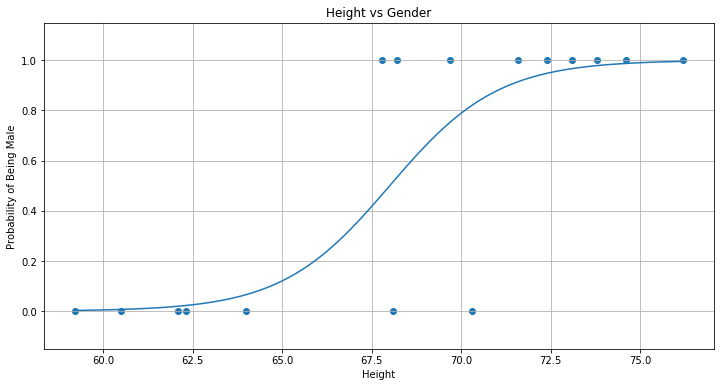

In [20]:
plt.figure(figsize=(12,6))
plt.grid()
plt.title("Height vs Gender")
plt.ylim([-0.15,1.15])
plt.scatter(Height,Gender)
plt.xlabel("Height")
plt.ylabel("Probability of Being Male")

X = np.linspace(min(Height),max(Height),100)     # now plot the probability curve against the height
Y = [predict(-44.95500076573667,0.6610740384798443,X[i]) for i in range(len(X))]         # this just to get it to compile, your code here

plt.plot(X,Y)
plt.show()

###  Part C

Now answer the following two questions:

     (i)  Your professor is 70 inches tall. What is the probability that he is male, according to this algorithm?
     
     (ii) The decision rule associated with this algorithm is that an input height is classified as male if the probability is 0.5 or higher.  Does this algorithm classify *your* gender correctly?

**Solution**


     

In [22]:
x = np.round(predict(-44.95500076573667,0.6610740384798443,70),4)
y = np.round(predict(-44.95500076573667,0.6610740384798443,72),4)

print("(i)", x)
print("(ii)", y, " yes, I'm 6' and a male.")

(i) 0.7892
(ii) 0.9335  yes, I'm 6' and a male.


## Machine Learning with the Naive Bayes Method

The Naive Bayes classification method is based on two fundamental concepts in probability theory: Bayes Theorem and Conditional Independence.

Suppose in the following we have a data set with $n$ values and a label which classifies the
vector into one of the labels in $\{a_1,\ldots,a_k\}$:

$$[\,\ldots\, (x_{1},x_{2},\ldots, x_{n},a)\,\ldots\,]$$



We may interpret this as a random variable $X=(X_1,X_2,\ldots, X_n)$ representing $n$ s of a data set and a random variable $A\in \{a_1,\ldots,a_k\}$, so that the joint random variable $(X,A)$ represents the result of a "classification" of $n$-tuples $(x_1,\ldots, x_n)$ into the set of category labels $A$. 

Essentially the question we want to answer in classification is: "Given our data set, what is the most probable label for a set of values $(x_1,x_2,\ldots, x_n)$?",  that is, we want to find $a_j\in A$ where

$$P(\,a_j\,|\,\,(x_1,x_2,\ldots, x_n)\,)$$

is the maximum.  This is the most likely label for this data.

Bayes theorem gives us a useful way to compute this probability. 

### Bayes Theorem

Bayes Theorem in its simplest form is as follows, for $X$ and $A$:


$$P(\,A\,|\,X\,)\,=\, {P(\,X\,|\,A\,)\cdot P(A)\over P(X)}$$

which for a particular instance $(\,x_1,\ldots, x_n,\, a_j\,)$ is: 

$$P(\,a_j\,|\,(x_1,\ldots, x_n)\,)\,)\,=\, {P(\,(x_1,\ldots, x_n)\,|\,a_j\,)\cdot P(a_j)\over P(x_1,\ldots, x_n)}$$

This means the probability we seek can be determined from the following:
  
  - $P(\,a_j\,)$  -- the probability of this label in the data set;
  - $P(\,x_1,x_2,\ldots, x_n\,)$  -- the probability of this vector of  values in the data set; and
  - $P(\,(x_1,x_2,\ldots, x_n)\,|\,a_j\,)$  -- the probability that this vector of  values would occur in instances with label $a_j$.

If we think of the training set as a set of "samples" from some infinite set of instances exemplifying the behavior of this phenomenon we are studying, then it appears that the data would give us a good estimate of the first, since we have a reasonably large data set and presumably the number of labels is small.  

However, with real data, even with simple data domains such as $\{0,1\}$,  the number of instances with an exact set of  values will normally be small, and will either be duplicates (if they have the same label) or confused (if they have diffent labels). Hence
the second third of these are difficult to estimate with precision from real data sets. 

To solve this, we will make an important assumption, based on the following notion. 


### Conditional Independence

Recall that events $X_1$ and $X_2$ are said to be *independent* iff

$$P(X_1\cap X_2)\,=\,P(X_1)\cdot P(X_2).$$

A version of this which takes account of independence in some context $A$ is as follows:
$X_1$ and $X_2$ are *conditionally independent* given $A$ iff

$$P(\,X_1\cap X_1 \,|\, A\,)\,=\, P(\,X_1\,|\,A\,)\cdot P(\,X_2\,|\,A\,)$$

This may be extended to more than two events:  $X_1,\ldots X_n$ are conditionally independent
given $A$ iff

$$P(\,X_1\cap \cdots \cap X_n\,|\, A\,)\,=\, P(\,X_1\,|\,A\,)\cdot P(\,X_2\,|\,A\,) \cdots P(\,X_n\,|\,A\,)$$

which, for a particular set of data values, would  be:

$$P(\,x_1,x_2,\ldots , x_n\,|\, a\,)\,=\, P(\,x_1\,|\,a\,)\cdot P(\,x_2\,|\,a\,) \cdots P(\,x_n\,|\,a\,)$$


### Naive Bayes Method

The **Naive Bayes Assumption** is that all of the values in a  set $X = (X_1,X_2,\ldots, X_n)$ are conditionally independent given the label set $A$,
that is, in assigning a label $a_j$ to a  set $(x_1,x_2,\ldots, x_n)$, each of the $x_i$ has an effect independent of the others.
This is hard to enforce,  hence the pejorative *naive*; however, the upshot is  that some
aspects of the data may be represented in multiple (non-independent) ways, which leads to
these aspects having more emphasis. This makes Naive Bayes less useful for complex data with high dimensionality,
but works fairly well for simple ML tasks, especially in text classification, which are often based on
the frequency of words. 

Now, assuming we have some a label set $A = (a_1,a_2,\ldots, a_k)$ and wish to classify a vector
$(x_1,x_2,\ldots, x_n)$, we choose the label $a_j$ which **maximizes** the probability

$$P(\,a_j\,|\,(x_1,x_2,\ldots, x_n)\,)\,=\,{P(x_1\,|\,a_j)\cdot P(x_2\,|\,a_j)\cdots P(x_n\,|\,a_j)\cdot P(a_j)\over P(x_1,x_2,\ldots, x_n)}$$

However, we have a fixed tuple $(x_1,x_2,\ldots, x_n)$, so the denominator is constant and can be factored out during the search for the maximum, so we have:

$$a_j\ =\ arg\,max_{a_j\in A} \left(\,P(\,x_1|\,a_j\,)\cdot P(\,x_2|\,a_j\,)\cdots P(\,x_n|\,a_j\,)\cdot P(\,a_j\,)\,\right)$$

where

$$P(\,x_i\,|\,a_j\,)\ =\ {\text{# occurrences of $x_i$ in instances with label $a_j$}\over\text{# occurrences of label $a_j$ in data set}}   $$

and

$$P(\,a_j\,)\ =\ {\text{# occurrences of label $a_j$ in data set}\over\text{size of data set}}   $$

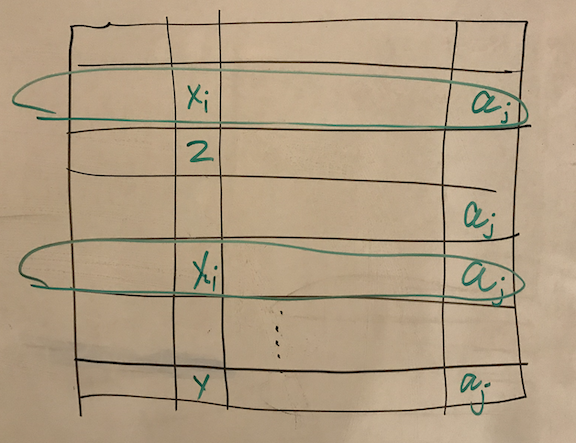

## DIY Naive Bayes Classification

In this section we derive the code for a Naive Bayes classifier, based on the preceeding analysis. 

In machine learning, the data, in whatever form it enters the system, is "vectorized" by turning it into
a list or vector of *features* which quantify an important characteristic of the data set. For example, 
a human subject in a medical analysis might be represented by a list of numbers giving their age, gender (e.g., 0 for male, 1 for female), height, weight, blood-pressure, and other health metrics.  


First we present a simple data set, consisting of binary numbers with three digits (as if "features" of a committee vote) 
and a bit indicating whether the
number is $\ge 2$ (labeled by 'G') or not (labeled by 'R'). This is the "voting function," as if the bits were voting on whether the label should be Green (a 0 = No is a vote for Red). 

| $x_1$ | $x_2$ | $x_2$ |$a$ | 
|:------|:-----:|:-----:|:---:|
|    1  | 1     | 1     | G  | 
|    1  | 1     | 0     | G |  
|    1  | 0     | 1     | G  |
|    1  | 0     | 0     | R | 
|    0  | 1     | 1     | G |
|    0  | 1     | 0     | R | 
|    0  | 0     | 1     | R |  
|    0  | 0     | 0     | R  |

If we view this in 3D, we see that there is a certain orientation of the Green and Blue points:

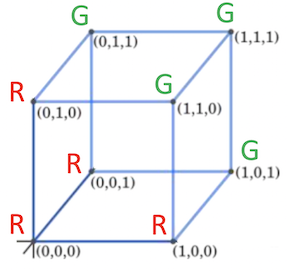

The green points are in the back and upper right, and the red on the opposite side of the cube, and the
the values in each dimension  are therefore similar. 
The question is:  **if we erased the color from one of these points, could the system figure out the missing color?**
To do so, it would have to see what the feature values of other other points would indicate. 

As our first example, we will use the last seven rows as the training data, and the first
row as the test: that is, given the training data, is the (unseen) binary number 111 larger or smaller than $2$?
(The point in question is in the middle of three green points!)

In order to perform the test, we separate out a "reference set" of data (the "answer key" to the test)
giving the correct answers. 

Training Set:

| $x_1$ | $x_2$ | $x_2$ |$a$ | 
|:------|:-----:|:-----:|:---:|
|    1  | 1     | 0     | G |  
|    1  | 0     | 1     | G  |
|    1  | 0     | 0     | R | 
|    0  | 1     | 1     | G |
|    0  | 1     | 0     | R | 
|    0  | 0     | 1     | R |  
|    0  | 0     | 0     | R  |

Reference Set:

| $x_1$ | $x_2$ | $x_3$ |$a$ | 
|:------|:-----:|:-----:|:---:|
|    1  | 1     | 1     | G  | 

Testing Set:

| $x_1$ | $x_2$ | $x_3$ |
|:------|:-----:|:-----:|
|    1  | 1     | 1     | 

Recall that we want to maximize the following probability:

$$a_j\ =\ arg\,max_{a_j\in A} \left(\,P(\,x_1|\,a_j\,)\cdot P(\,x_2|\,a_j\,)\cdots P(\,x_n|\,a_j\,)\cdot P(\,a_j\,)\,\right)$$

where $(x_1,x_2,x_3)\,=\,(1,1,1)$ and $a\,\in\,\{\,G, R\,\}$. 

For the label set, we have:

$$P(\,G\,)\,=\, 3/7\quad\quad P(\,R\,)\,=\, 4/7$$

For $a=G$, we have:

$$P(\,x_1 = 1\,|\,G\,)\,=\, 2/3\quad\quad P(\,x_2 = 1\,|\,G\,)\,=\, 2/3\quad\quad P(\,x_3 = 1\,|\,G\,)\,=\, 2/3$$

so $$P(\,(1,1,1)\,|\,G\,)\,=\, (2/3)(2/3)(2/3)(3/7) \,=\, 0.127$$

and for $a=R$, we have:

$$P(\,x_1 = 1\,|\,R\,)\,=\, 1/4\quad\quad P(\,x_2 = 1\,|\,R\,)\,=\, 1/4\quad\quad P(\,x_3 = 1\,|\,R\,)\,=\, 1/4$$

so $$P(\,(1,1,1)\,|\,G\,)\,=\, (1/4)(1/4)(1/4)(4/7) \,=\, 0.0089.$$



which yields a correct classification that this feature set is G.  


We now proceed to code up this process, which for the most part is a straight-forward implementation of the ideas just presented. There are two aspects of the algorithm worth noting, however:


  - As remarked above, data is usually represented by a "feature vector", which is most conveniently represented by a Python dictionary mapping feature names to values.  
    
  - The Naive Bayes method suffers from an inability to deal with missing values in the data: note that if in the computation of the value $P(\,x_i|\,a_j\,)$, the value $x_i$ does NOT occur associated with the label $a_j$,
    then the whole expression $\,P(\,x_1|\,a_j\,)\cdot P(\,x_2|\,a_j\,)\cdots P(\,x_n|\,a_j\,)\cdot P(\,a_j\,)$ will be 0. However, the implication -- that such data is literally impossible -- is not realistic, given that
    our data is in some sense a "sample" from a larger set of possible behaviors in the real world. 
    
    Therefore, *additive smoothing* is performed when counting the numerator in 
    
    $$P(\,x_i\,|\,a_j\,)\ =\ {\text{# occurrences of $x_i$ in instances with label $a_j$}\over\text{# occurrences of label $a_j$ in data set}}   $$
    
    The simples version of smoothing is simply to forbid 0 counts by adding 1 every time this numerator is calculated, preserving (mostly) the scale of the counting, but disallowing 0 counts. 

In [103]:
data_set_A  =     [ ( {'x1': 1, 'x2': 1, 'x3': 1}, 'G' ),      # 111  G  
                  ( {'x1': 1, 'x2': 1, 'x3': 0}, 'G' ),      # 110  G  
                  ( {'x1': 1, 'x2': 0, 'x3': 1}, 'G' ),      # 101  G           
                  ( {'x1': 1, 'x2': 0, 'x3': 0}, 'R' ),      # 100  R     
                  ( {'x1': 0, 'x2': 1, 'x3': 1}, 'G' ),      # 011  G       
                  ( {'x1': 0, 'x2': 1, 'x3': 0}, 'R' ),      # 010  R  
                  ( {'x1': 0, 'x2': 0, 'x3': 1}, 'R' ),      # 001  R
                  ( {'x1': 0, 'x2': 0, 'x3': 0}, 'R' )       # 000  R  
                ]

def run_example(data_set,test_index=0):
    
    features = ['x1', 'x2', 'x3']
    
    print("\nFeatures:", features)

    labels = set([label for (data,label) in data_set])

    print("\nLabels:", labels)

    def pprint(ds):
        for (d,lab) in ds:
            print((list(d.values()),lab))

    # test_index gives row to use for testing, others are for training

    reference_set = data_set[test_index:test_index+1]

    test_set = reference_set[0][0]

    training_set = data_set[:test_index] + data_set[(test_index+1):]

    print("\nTraining set:")
    pprint(training_set)

    print("\nReference Set:")
    pprint(reference_set)

    M = len(training_set)

    # find count of labels occurring in training set

    label_histogram = Counter( [ a for (x,a) in training_set ] )

    def Pa(aj):
        return label_histogram[aj] / M

    print("\nLabel Probabilities:", [(label,Pa(label)) for label in labels])

    # Return probability of (feature:value) given label

    additive_smoothing = True

    def Pxa(feature,value,label):
        numerator = sum([ 1 for (fs,lab) in training_set if fs[feature] == value and lab == label ]) 
        if additive_smoothing:
            numerator += 1
        return (numerator / label_histogram[label]) 

    def probOfLabel(X,aj):
        return np.prod( [ Pxa(f,v,aj) for (f,v) in X.items() ] ) * Pa(aj)


    # Now, given feature set X (dictionary), find label with highest probability
    # first create set of pairs (label, prob) and then sort

    def rank_labels(X):
        Res = [(aj,probOfLabel(X,aj)) for aj in labels ] 
        return sorted(Res, key = lambda x: x[1], reverse=True) 

    print("\nRanking of labels for test:", rank_labels(test_set))

    def classify(X):
        return rank_labels(X)[0][0]

    LS = rank_labels(test_set)
    c = LS[0][0]

    if LS[0][1] == LS[1][1]:         # first two probabilities the same
        print("\nAmbiguously classified as: ", c)
    elif c == reference_set[0][1]:
        print("\nCorrectly classified as: ", c)
    else:
        print("\nWrongly classified as: ", c)

run_example(data_set_A,0)


Features: ['x1', 'x2', 'x3']

Labels: {'G', 'R'}

Training set:
([1, 1, 0], 'G')
([1, 0, 1], 'G')
([1, 0, 0], 'R')
([0, 1, 1], 'G')
([0, 1, 0], 'R')
([0, 0, 1], 'R')
([0, 0, 0], 'R')

Reference Set:
([1, 1, 1], 'G')

Label Probabilities: [('G', 0.42857142857142855), ('R', 0.5714285714285714)]

Ranking of labels for test: [('G', 0.42857142857142855), ('R', 0.07142857142857142)]

Correctly classified as:  G


## Problem Two: Naive Bayes Classification

This problem will just explore the Naive Bayes method in the context of the labeled unit square
just presented. 

The main question is:  If one of these rows of data is missing, can it be inferred from the
remaining data using machine learning?

It will turn out that classification is easier when the cateogories group together in some
way that can be described easily (say with a line drawn between the two groups).



### Part A

Run the code in the previous cell, using

>      run_example(data_set_A,randint(8))

to see the effect of missing out various rows, and observe when the classification seems to work well, and when it doesn't.
Notice the probabilities given
for each of the labels during your investigations and in particular, when they are the same (in which case
the classifier makes a random choice, which is indicated by "Ambiguously..."

Which rows (when submitted as tests) are correctly classified and which are not?  In which cases is the classification based on a higher probability and when it is ambiguous in that it seems to be based on the random arrangement of two equal probabilities?

Can you relate this to the 3D diagram in any way? (Think about how you might draw a line (or, a plane) through
this diagram to separate the R and G points -- classification is easier when you can clearly separate the categories with  a simple line or plane.)

Hint: You can easily draw a line (really a plane) between
the two kinds of points:

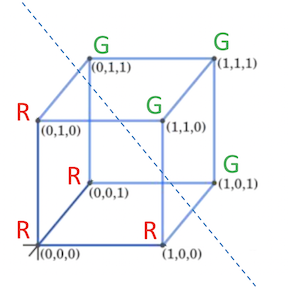

In [40]:
run_example(data_set_A,randint(8))


Features: ['x1', 'x2', 'x3']

Labels: {'G', 'R'}

Training set:
([1, 1, 1], 'G')
([1, 1, 0], 'G')
([1, 0, 1], 'G')
([1, 0, 0], 'R')
([0, 1, 1], 'G')
([0, 1, 0], 'R')
([0, 0, 1], 'R')

Reference Set:
([0, 0, 0], 'R')

Label Probabilities: [('G', 0.5714285714285714), ('R', 0.42857142857142855)]

Ranking of labels for test: [('R', 0.42857142857142855), ('G', 0.07142857142857142)]

Correctly classified as:  R


### Part B

Now I want you to run the code using the following data set, in which one line has changed, changing the upper-left-rear point from green to red:

In [27]:
data_set_B  =   [ ( {'x1': 1, 'x2': 1, 'x3': 1}, 'G' ),      # 111  G  
                  ( {'x1': 1, 'x2': 1, 'x3': 0}, 'G' ),      # 110  G  
                  ( {'x1': 1, 'x2': 0, 'x3': 1}, 'G' ),      # 101  G           
                  ( {'x1': 1, 'x2': 0, 'x3': 0}, 'R' ),      # 100  R     
                  ( {'x1': 0, 'x2': 1, 'x3': 1}, 'R' ),      # 011  G => R       
                  ( {'x1': 0, 'x2': 1, 'x3': 0}, 'R' ),      # 010  R  
                  ( {'x1': 0, 'x2': 0, 'x3': 1}, 'R' ),      # 001  R
                  ( {'x1': 0, 'x2': 0, 'x3': 0}, 'R' )       # 000  R  
                ]

This effectively makes the whole left side of the square red (in other words, the color red *mostly* coincides with the first bit being 0). Algorithmically, this is categorizing binary numbers as those $\ge 5$ (G) and those $<5$ (R). 

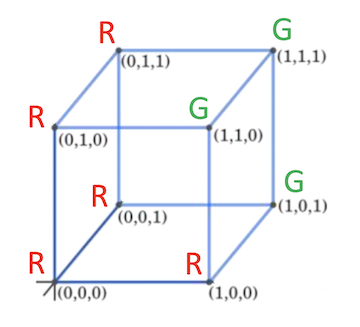

It is hard to see what effect this will have, but let's explore...

Perform the same experiment as in Part A,  testing each row to see if it can be inferred from the remaining data. 
How has the classification process changed?  Are there any ambiguous classifications (where the probabilities
of the two labels were the same?)?  Explain why you think any points misclassified ended up with that result. 

How is this different from Part A?    

In [43]:
run_example(data_set_B,randint(8))

print()
print("ANSWER - For some reason, and after a dozen or so tests each, I feel like B tends to guess correctly more often than A.")


Features: ['x1', 'x2', 'x3']

Labels: {'G', 'R'}

Training set:
([1, 1, 1], 'G')
([1, 0, 1], 'G')
([1, 0, 0], 'R')
([0, 1, 1], 'R')
([0, 1, 0], 'R')
([0, 0, 1], 'R')
([0, 0, 0], 'R')

Reference Set:
([1, 1, 0], 'G')

Label Probabilities: [('G', 0.2857142857142857), ('R', 0.7142857142857143)]

Ranking of labels for test: [('G', 0.21428571428571427), ('R', 0.13714285714285715)]

Correctly classified as:  G

ANSWER - For some reason, and after a dozen or so tests each, I feel like B tends to guess correctly more often than A.


### Part C

Now we change the following two lines in the data set, to switch the point 011 from G to R and 100 from R to G:

In [44]:
data_set_C  =   [ ( {'x1': 1, 'x2': 1, 'x3': 1}, 'G' ),      # 111  G  
                  ( {'x1': 1, 'x2': 1, 'x3': 0}, 'G' ),      # 110  G  
                  ( {'x1': 1, 'x2': 0, 'x3': 1}, 'G' ),      # 101  G           
                  ( {'x1': 1, 'x2': 0, 'x3': 0}, 'G' ),      # 100  R => G   
                  ( {'x1': 0, 'x2': 1, 'x3': 1}, 'R' ),      # 011  G => R       
                  ( {'x1': 0, 'x2': 1, 'x3': 0}, 'R' ),      # 010  R  
                  ( {'x1': 0, 'x2': 0, 'x3': 1}, 'R' ),      # 001  R
                  ( {'x1': 0, 'x2': 0, 'x3': 0}, 'R' )       # 000  R  
                ]

This effectively makes the whole left side of the square red and the whole right side green. In other words, the color is completely determined by the first bit, separating into points $\ge 4$ (G) and $<4$ (R). 

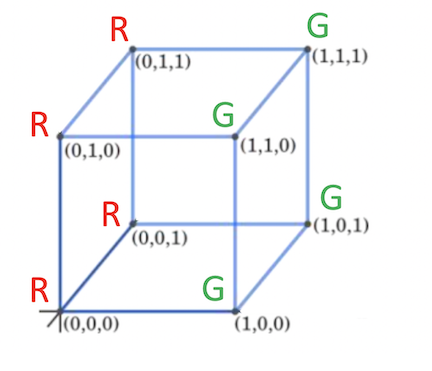

Before testing this out, consider whether you think this will make classification easier or harder. Notice that
one of the bits gives very clear indication of the color!

Then run tests as before and explain whether your initial thoughts about this were confirmed by your tests.

In [56]:
run_example(data_set_C,randint(8))

print()
print("ANSWER - After a handful of tests, it seems like the algorithm has guessed every single one correctly.")


Features: ['x1', 'x2', 'x3']

Labels: {'G', 'R'}

Training set:
([1, 1, 1], 'G')
([1, 0, 1], 'G')
([1, 0, 0], 'G')
([0, 1, 1], 'R')
([0, 1, 0], 'R')
([0, 0, 1], 'R')
([0, 0, 0], 'R')

Reference Set:
([1, 1, 0], 'G')

Label Probabilities: [('G', 0.42857142857142855), ('R', 0.5714285714285714)]

Ranking of labels for test: [('G', 0.25396825396825395), ('R', 0.08035714285714285)]

Correctly classified as:  G

ANSWER - After a handful of tests, it seems like the algorithm has guessed every single one correctly.


### Part D

Once more! Now we will mix up the points as completely as possible, so that no green is next to a red point:

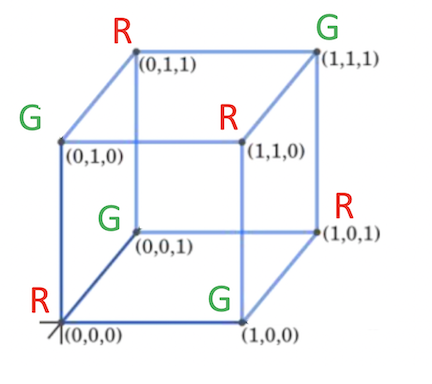

(This is separating the points into those with an even number of ones (even parity) (R) and odd parity (G).)

Before testing this out, consider whether you think this will make classification easier or harder. 
It is certainly hard to see how to separate out the point visually, and there is no single bit that
plays a significant role. 

Then run tests as before, describe what you see,  and explain whether your initial thoughts about this were confirmed by your tests. 


In [64]:
data_set_D  =   [ ( {'x1': 1, 'x2': 1, 'x3': 1}, 'R' ),      # 111  R  
                  ( {'x1': 1, 'x2': 1, 'x3': 0}, 'G' ),      # 110  G  
                  ( {'x1': 1, 'x2': 0, 'x3': 1}, 'R' ),      # 101  R           
                  ( {'x1': 1, 'x2': 0, 'x3': 0}, 'G' ),      # 100  G    
                  ( {'x1': 0, 'x2': 1, 'x3': 1}, 'R' ),      # 011  R        
                  ( {'x1': 0, 'x2': 1, 'x3': 0}, 'G' ),      # 010  G  
                  ( {'x1': 0, 'x2': 0, 'x3': 1}, 'R' ),      # 001  R
                  ( {'x1': 0, 'x2': 0, 'x3': 0}, 'G' )       # 000  G  
                ]

run_example(data_set_D,randint(8))

print()
print("ANSWER - Once again, it seems like the algorithm has guessed every single one correctly.")


Features: ['x1', 'x2', 'x3']

Labels: {'G', 'R'}

Training set:
([1, 1, 1], 'R')
([1, 1, 0], 'G')
([1, 0, 1], 'R')
([1, 0, 0], 'G')
([0, 1, 0], 'G')
([0, 0, 1], 'R')
([0, 0, 0], 'G')

Reference Set:
([0, 1, 1], 'R')

Label Probabilities: [('G', 0.5714285714285714), ('R', 0.42857142857142855)]

Ranking of labels for test: [('R', 0.25396825396825395), ('G', 0.08035714285714285)]

Correctly classified as:  R

ANSWER - Once again, it seems like the algorithm has guessed every single one correctly.


## The Machine Learning Pipeline (for Movie Reviews)

Machine learning tasks typically involve the following steps, some of which
may be handled by software (e.g., `sklearn`) and some of which, like the original data collection, you may have to do yourself.  

The typical Machine Learning "Pipeline" is as follows:

  - **Ingestion:**  Collecting the data into computer storage;
  - **Data Wrangling:** Cleaning and formatting the data for the ML task you have;
  - **Model Selection:** Choosing the appropriate modeling algorithm (e.g., Naive Bayes) for your ML task;
  - **Feature Engineering:** Transforming you data into a feature set appropriate for your modeling algorithm;
  - **Data Vectorization and Formatting:** Transform the data into feature vectors (usually called feature sets) and separate into training and testing sets. 
  - **Evaluation and Testing:** Run the classifier on the data: how well did you do with the choices you made in the previous two steps? 
  - [Repeat the previous two steps as necesssary to achieve your goals]
  - **Deployment:** Putting your ML algorithm to work to accomplish something. 
  
We will stick with the Naive Bayes classifier for this homework, and only work with textual data, and we'll do the
data wrangling for you, so much of our work concerns
feature engineering and evaluation/testing.  However, we DO need to convert our
data into an appropriate form for the classifier to work on. 

### Data Ingestion for Document Processing

In some cases, there is so much data that managing the disk and main memory is a complicated
process, because all the data will not fit into memory at one time. In our case, however, we have
simple text data files, and ingestion simply means reading into an appropriate data structure. 

So the first step is to input all the data using the `classification_corpus_reader` provided in
the first code cell to store each document as a pair

>     ( list-of-words,  label  )

where in this case the documents are movie reviews and the labels are `pos` and `neg`. 

In [70]:
# Example: Movie Reviews

(movie_review_words, movie_review_docs) = classification_corpus_reader(['movie_reviews'])


In [71]:
len(movie_review_words)

1336782

In [72]:
len(movie_review_docs)

2000

In [73]:
print(movie_review_docs[0][0][:10])
print(movie_review_docs[0][1])

['plot', 'two', 'teen', 'couples', 'go', 'to', 'a', 'church', 'party', 'drink']
neg


### OPTIONAL:  Data Wrangling: Cleaning and Formatting

As you can see in the previous cell, there are some issues with the data presented to us for the
movie review corpus, for example, the way punctuation is dealt with. Each project is a little different, but
typically you will need to pre-process the data to facilitate later steps. The process of data wrangling
to get ready for next phase in the pipeline can take *more than half the entire time* for the project!


Some typical tasks in this part of the pipeline include:

   - Conversion of all words to lower case (to make the process case-insensitive)
   - Elimination of punctuation and other extraneous characters
   - Removal of stop words
   - Managing missing or `null` data
   - Stemming or tagging words or sentences
   - Reformatting or otherwise reorganizing the data


The data in our example has been processed already, and so we will skip this step! You will
certainly have to do this when you work on your own data project!


**DIGRESSION:  Using Sets instead of Lists**
    
In general, it is better to store collections as sets (which are implemented by hash tables) instead
of lists; accessing a hash table is $O(1)$ compared with $O(n)$ for lists. 

Sets, compared with lists, have no order and no duplicates;
hence they are a simple way to reduce a collection to just the unique elements: 

Therefore, any collection which will be accessed frequently, and for which ordering does
not matter, should be stored as sets. The basic operations on sets are as follows:

In [74]:
S = set( [1,2,3,4,2,4,1] )
print(S)
S.add(5)                 # S is changed "in place"
print(S)
S.remove(2)
print(S)
T = S.union( set( [8,6,9,6]) )      # S is unchanged, but the union is returned as result
print(S)
print(T)
U = S.intersection( set( [2,6,3]) )
print(U)

{1, 2, 3, 4}
{1, 2, 3, 4, 5}
{1, 3, 4, 5}
{1, 3, 4, 5}
{1, 3, 4, 5, 6, 8, 9}
{3}


In [75]:
movie_review_words_set = set(movie_review_words)
print(len(movie_review_words))
print(len(movie_review_words_set))
len(movie_review_words_set)/len(movie_review_words)

1336782
39696


0.02969519338231664

**END OF DIGRESSION on Sets**

### Feature Engineering

Encoding the (cleaned) text into feature vectors (usually called "features sets") involves first of all choosing features.  Some simple feature sets based on vocabulary in texts (land which should look familiar) are

  - **One-Hot Encoding:**  Features are 0/1 values recording presence of words:  { 'man' : 1 }
  - **Term Frequency:** Features are integers recording number of occurrences of words: { 'man' : 2 }
  
There are many other possibilities, as we saw for the Names example last time. 
  
[OPTIONAL!] The vectors/sets may then be further processed, for example:

  - **Normalization and Scaling:** Feature values are sometimes normalized to be of a similar scale, for example, all values may be converted to floats in the range [0..1]. We will not pursue this option in this notebook. 
  - **Term Frequency-Inverse Document Frequency:** 
  
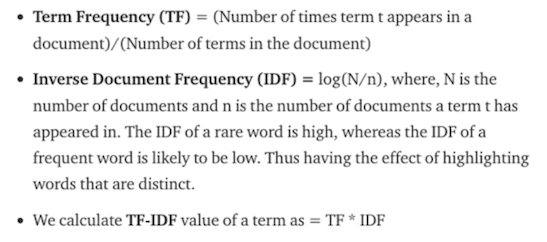

## Problem Three: Building Feature Vectors

A feature set or vector is simply a mapping from feature names (usually strings)
to values (could be anything, but we will use small integers). A Python
dictionary is a great way to implement this, and usually we will use
a version of a Python dictionary which gives "default values" when
a key is not found (instead of throwing a KeyError exception):
<pre>
D = {}

D['a']
---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
<ipython-input-9-65ac57e10756> in <module>()
      1 D = {}
      2 
----> 3 D['a']

KeyError: 'a'
</pre>

In [76]:
D = defaultdict(int)                 # the default value for ints is 0
D['a']

0

### Part (A)  One Hot Feature Vectors

A "One Hot" feature vector is a dictionary which simply records the presence or absence of
a word in a piece of text. Essentially, it creates a vocabulary listing of the text, without
indicating the frequency of each word.  By using default dictionaries, we can
avoid having to store lots of 0's in the dictionary for words not present. 

In this next cell, complete the function as shown. 

In [89]:
# Standard implementation of the above

# Given a list of words, encode using the One-Hot method

def one_hot_feature_set(text):
    features = defaultdict(int)               # this will return 0 for any key not in the dictionary
    features2 = defaultdict(int)
    
    # Your code here
    features.update({ c: 1 for c in text })
    
    return features

# Should return:  defaultdict(int, {'a': 1, 'b': 1, 'c': 1, 'e': 1})

one_hot_feature_set(['a','b','c', 'e', 'e', 'b'])

defaultdict(int, {'a': 1, 'b': 1, 'c': 1, 'e': 1})

### Part (B)  Term Frequency Feature Vectors

The term frequency approach is to actually count the number
of occurrence of each word. It is in essence a histogram of
the vocabulary in the text. 

In this next cell, complete the function as shown. 

In [80]:
def term_frequency_feature_set(text):
    features = defaultdict(int)

    # Your code here
    features.update({ c:(text.count(c)) for c in text })
    
    return features

# Should return:  defaultdict(int, {'a': 1, 'b': 2, 'c': 1, 'e': 2})

term_frequency_feature_set(['a','b','c', 'e', 'e', 'b'])

defaultdict(int, {'a': 1, 'b': 2, 'c': 1, 'e': 2})

### Vectorization and Formatting

Now we must convert our (cleaned) documents to feature sets plus labels, and
split into training and testing sets. We will reserve 5% of our data for testing. 

We will put all our code into one function to facilitate testing various options. 

In [83]:
# Turn list of documents into feature sets and separate into testing and training sets. 

def vectorize(feature_set_builder, documents, percent_testing = 0.05):

    # Choose a feature set representation and transform data set into feature sets and labels:

    documents_vectorized = [ (feature_set_builder(ws),label) for (ws,label) in movie_review_docs ]

    limit = int(len(documents)*percent_testing)

    # Randomize before picking the testing and training sets

    seed(0)      # to make sure shuffle is random but is the same every time, for testing

    shuffle(documents_vectorized)

    # extract the training set

    documents_training = documents_vectorized[limit:]

    # extract reference set (testing set with correct labels, for evaluation)

    documents_reference = documents_vectorized[:limit]

    return (documents_training, documents_reference)

In [90]:
(movie_review_training, movie_review_reference) = vectorize(one_hot_feature_set, movie_review_docs)

In [91]:
len(movie_review_docs)

2000

In [92]:
len(movie_review_reference)

100

### Testing and Evaluation

Finally, we must test our classifier and see how well it learned! We have to do some grading!
After summarizing what metrics seem to be most useful, we will test our movie review classifier. 


### Performance Measures

The most obvious measure is the simplest: 

   - Accuracy -- Percentage of test instances classified correctly


Other metrics are based on a more subtle analysis of what went wrong or right, by
creating a "confusion matrix" of all the possible outcomes of the classification.

Supposing we have a label $A$ for a category, and we wish to determine simply if an instance is a member of $A$ or not. We can have 4 possible results, 
where "positive" means the instance was labeled as belonging to $A$, 
and "negative" means it was not labeled as belonging to A:

   - **True Positive:**    Correctly labeled as belonging to category A
   - **True Negative:**    Correctly labeled as NOT belonging to category A
   - **False Positive:**   Incorrectly labeled as A
   - **False Negative:**   Incorrectly labeled as NOT belonging to A

### Confusion Matrix

The **Confusion Matrix** for this situation shows all the possibilities:

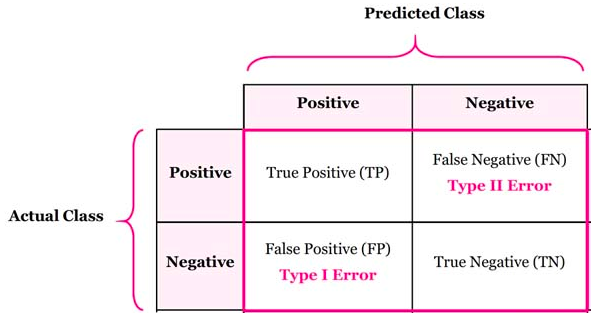

   
How well did your classifier do on these? The common metrics for evaluating the performance of a classifier are based
on these four values:

$$\begin{align}
\text{Accuracy} \, &=\, {\text{True Predictions}\over\text{All Predictions}}\,=\,{T \,A + T \,\neg A\over T \,A + T \,\neg A + F \,A + F \,\neg A }\\[12pt]
\text{Precision} \,&=\,{T \,A\over T \,A +  F \, A}\\[12pt]
\text{Recall} \,&=\,{T \,A\over T \,A +  F \,\neg A}\\[12pt]
\end{align}$$

Intuitively, these make good sense:

   - Accuracy is simply how many predictions were correct;
   - Precision is the percentage of the positive predictions you got right; 
   - Recall is the percentage of the instances actually IN A were identified correctly. 


The idea of *accuracy* is fairly straight-forward: how many did it get correct?
However, the others are useful in many circumstances where the *cost* of errors may be unacceptable:

   - If $A$ = the patient has cancer, then $F\neg A$ is disasterous, since you have missed diagnosing a deadly disease, so we want to increase *recall*;
   - If you are trying to classify documents to retrieve them, then recall tells you
     how many of the relevant documents were retrieved (or recalled, hence the name); 
   
Conversely, if $A$ = the patient is cancer-free, then we flip the situation, 
and precision becomes more important!

There are other metrics (less used), as summarized in this diagram:

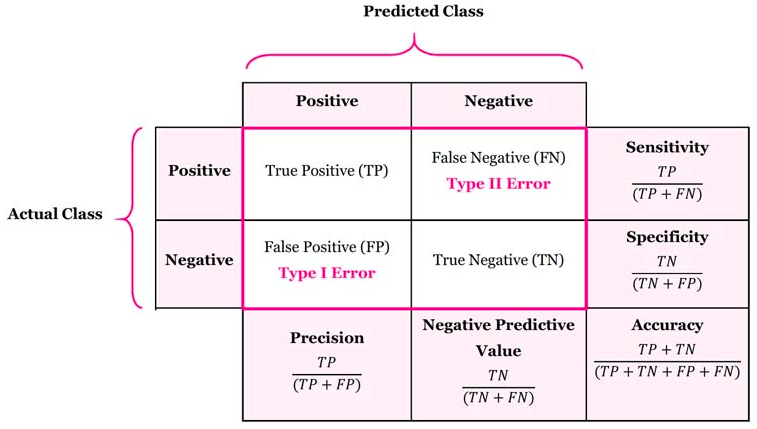

Precision and recall often in conflict: increasing one will decrease the other; in this case,
a composite measure is often used, which attempts to equalize the error between these two:

$$\text{F_measure}\,=\, {2 \times \text{Precision} \times \text{Recall}\over \text{Precision} + \text{Recall}}$$

The F_measure will be closer to the smaller of the two.  



The following cell will build a classifier for the given corpus and feature sets specified
in the first two lines.  

## Problem Four:  Building and Testing a Movie Review Classifier using One Hot Vectors


### Part A: Building the `review_classifier`

In this problem, you must simply rewrite the code from the `run_example` function above to
build a classifier `review_classifier` for our movie review corpus.  You may put this
in a function or just write code in the cell. Don't change the original code, copy down here
and change it!

Hint: `run_example` has everything you need, so you just need to cut and paste and rename
some variables. Begin by constructing the `label_histogram` and end by defining
the classifier as indicated. 


In [128]:
# These steps already done above, but if you change the corpus or the feature sets, will need to rerun these

(movie_review_words, movie_review_docs) = classification_corpus_reader(['movie_reviews'])
#                                                                       ^^^^^^^^^^^^^^^
(movie_review_training, movie_review_reference) = vectorize(one_hot_feature_set, movie_review_docs,0.05)
#                                                           ^^^^^^^^^^^^^^^^^^^

## YOUR CODE HERE
M = len(movie_review_training)

label_histogram = Counter( [ a for (x,a) in movie_review_training ] )

def Pa(aj):
    return label_histogram[aj] / M

additive_smoothing = True

def Pxa(feature,value,label):
    numerator = sum([ 1 for (fs,lab) in movie_review_training if fs[feature] == value and lab == label ]) 
    if additive_smoothing:
        numerator += 1
    return (numerator / label_histogram[value] ) 

def probOfLabel(X,aj):
    return np.prod( [ Pxa(f,v,aj) for (f,v) in X.items() ] ) * Pa(aj)

def rank_labels(X):
    Res = [(aj,probOfLabel(X,aj)) for aj in movie_review_reference ] 
    return sorted(Res, key = lambda x: x[1], reverse=True) 

def review_classifier(X):
    return rank_labels(X)[0][0]



TypeError: unhashable type: 'collections.defaultdict'

In [ ]:
# Test your code:
for k in range(10):
    print(movie_review_reference[k][1], review_classifier(movie_review_reference[k][0]))  


### Part (B)  Testing the Movie Review Classifier

We will use a function `test_classifier` to test our classifier.  This will create a Naive Bayes classifier from the data and report on its performance. 

The only part missing is the calculation of true and false results, as explained above. 
You must complete this part of the template and run the code as indicated. 

In [ ]:
def test_classifier(classifier, reference_set):
    result = [ (fs,lab,classifier(fs)) for (fs,lab) in reference_set]

    TP = TN = FP = FN = 0
    
    # Your code here.  Note that result holds a list of pairs (fs, l1, l2) and you have
    # to count how many in each category:  
    #      TP:    (_, 'pos','pos')
    #      TN:    (_, 'neg','neg')
    #      FP:    (_, 'neg','pos')
    #      FN:    (_, 'pos','neg')


    acc = 0                 # use the formulae give above
    recall = 0
    prec = 0
    f_measure = 0
    
    
    
    print("\nConfusion Matrix:")
    print()
    print('{:3s}  | {:5s}   | {:5s}   |'.format(' ','Pos', 'Neg'))
    print("--------------------------")
    print('{:3s} | {:2s} {:3d} | {:2s} {:3d} |'.format('Pos:','TP:', TP, 'FN:', FN))
    print("--------------------------")
    print('{:3s} | {:2s} {:3d} | {:2s} {:3d} |'.format('Neg:','FP:', FP, 'TN:', TN))
    print("--------------------------")
    print("(row = reference; col = test)\n")
    print("Accuracy:\t",round4(acc))
    print("Recall:  \t",round4(recall))
    print("Precision:\t",round4(prec))
    print("F-Measure:\t",round4(f_measure))

In [ ]:
test_classifier(review_classifier, movie_review_reference)

### Part (C)  Term Frequency Feature Sets

Another alternative to the "One Hot" method (which just checked for the presence or absence of
words) is to actually count the number of occurrences, not just record them as 0 or 1. 

For this part, rerun your code with the `term_frequency_feature_set` feature set builder defined above,
and see if it gives you better accuracy.   You can copy the code down to a new cell or run it
above, but make sure you rerun the original before you submit. 

Then answer the following question:  Were the results different than the One Hot method?
Why or why not?   (Hint: think about when the two methods would be different, and whether
in a short review this is likely to happen very often.) 


## Problem Five:  Using Sentiment Analysis

In the previous problem, we tried to learn how positive and negative reviews differed
in their choice of words.  But some words are inherently positive or negative.
In this problem, we will use a list of positive and negative words, and
simply check for their presence in the texts.  

Fill in the templates where indicated, and at the end, write a short response: Why do you think this
last method worked better or worse than the previous ones?

In [44]:
try:
    f_pos = open('./sentiment_words/positive_words.txt','r', encoding='latin-1')
    pos_words = f_pos.readlines()
    print(len(pos_words), 'positive words read.')
    f_pos.close()
    f_neg = open('./sentiment_words/negative_words.txt','r', encoding='latin-1')
    neg_words = f_neg.readlines()
    print(len(neg_words), 'negative words read.')
    f_neg.close()
except IOError:
    print("Error: File does not appear to exist!")
    
positive_words = set([ w.strip() for w in pos_words])
negative_words = set([ w.strip() for w in neg_words])

sentiment_words = positive_words.union(negative_words)

2006 positive words read.
4783 negative words read.


### Part A

In this next cell, you must modify the One Hot feature set constructor so that
it ONLY considers sentiment words when it builds the feature set.
This is an easy change from the One Hot method given above. 

In [ ]:
# create feature set from list of words in the document

def sentiment_feature_set(text):
    fs = defaultdict(int)
    
    # Your code here
    
    return fs

# Test: should give you:   defaultdict(int, {'happy': 1, 'terrible': 1, 'wonderful': 1})
sentiment_feature_set(['happy', 'movie', 'terrible', 'wonderful','seagal','terrible',])

### Part B

Now rewrite the code to use this new feature set builder.  Does it do better?  
Add a brief comment explaining why you think the results turned out this way. 